# Polygenic Risk Scores

The csv files were extracted from this file: `data/ROSMAP_SEAAD_AD_107.rds`, using the following 3 lines of R code:

```R
df <- readRDS("data/ROSMAP_SEAAD_AD_107.rds")
write.csv(df[1], "data/SNPs_metadata.csv", row.names = TRUE)
write.csv(df[2], "data/SNPs.csv", row.names = TRUE)
```

The weights used to calculate the PRSs are downloaded from `https://www.ebi.ac.uk/gwas/studies/GCST90027158`, which are the results from this study: `https://www.nature.com/articles/s41588-022-01024-z`. Stored in this file: `data/gwas-association-downloaded_2025-06-19-accessionId_GCST90027158.tsv`

The polygenic risk score $PRS_i$ for sample $i$ is then calculated using:
$$
PRS_i = \sum_{j=1}^M \beta_j \cdot G_{ij}
$$

where $\beta_j$ are the weights from the study (odds-ratio), and $G_{ij}$ the dosage of risk SNP $j$ in sample $i$

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [ ]:
snps = pd.read_csv("data/SNPs.csv", index_col=0)
snps_meta = pd.read_csv("data/SNPs_metadata.csv", index_col=0).replace({"TRUE": "T"})  # Fix a small mistake in the metadata
weights = pd.read_csv("data/gwas-association-downloaded_2025-06-19-accessionId_GCST90027158.tsv", sep="\t", index_col="SNPS")

In [246]:
"rs429358" in weights.index, "rs7412" in weights.index  # Check if the two APOE SNPs are in the weights

(False, False)

In [247]:
weights

,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,GENOTYPING TECHNOLOGY
SNPS,,,,,,,,,,,,,,,,,,,,,
rs141749679,2022-04-06,35379992,Bellenguez C,2022-04-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/35379992,New insights into the genetic etiology of Alzh...,Alzheimer's disease,"39,106 European ancestry clinically diagnosed ...","25,392 cases, 276,086 controls",...,8.096910,NaN,1.38,[1.24-1.54],"Affymetrix, Illumina [21101114] (imputed)",N,Alzheimer disease,http://purl.obolibrary.org/obo/MONDO_0004975,GCST90027158,Genome-wide genotyping array
rs13237518,2022-04-06,35379992,Bellenguez C,2022-04-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/35379992,New insights into the genetic etiology of Alzh...,Alzheimer's disease,"39,106 European ancestry clinically diagnosed ...","25,392 cases, 276,086 controls",...,10.301030,NaN,0.96,[0.94-0.97],"Affymetrix, Illumina [21101114] (imputed)",N,Alzheimer disease,http://purl.obolibrary.org/obo/MONDO_0004975,GCST90027158,Genome-wide genotyping array
rs1160871,2022-04-06,35379992,Bellenguez C,2022-04-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/35379992,New insights into the genetic etiology of Alzh...,Alzheimer's disease,"39,106 European ancestry clinically diagnosed ...","25,392 cases, 276,086 controls",...,8.000000,NaN,0.95,[0.93-0.97],"Affymetrix, Illumina [21101114] (imputed)",N,Alzheimer disease,http://purl.obolibrary.org/obo/MONDO_0004975,GCST90027158,Genome-wide genotyping array
rs17020490,2022-04-06,35379992,Bellenguez C,2022-04-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/35379992,New insights into the genetic etiology of Alzh...,Alzheimer's disease,"39,106 European ancestry clinically diagnosed ...","25,392 cases, 276,086 controls",...,8.522879,NaN,1.06,[1.04-1.08],"Affymetrix, Illumina [21101114] (imputed)",N,Alzheimer disease,http://purl.obolibrary.org/obo/MONDO_0004975,GCST90027158,Genome-wide genotyping array
rs143080277,2022-04-06,35379992,Bellenguez C,2022-04-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/35379992,New insights into the genetic etiology of Alzh...,Alzheimer's disease,"39,106 European ancestry clinically diagnosed ...","25,392 cases, 276,086 controls",...,12.698970,NaN,1.47,[1.33-1.63],"Affymetrix, Illumina [21101114] (imputed)",N,Alzheimer disease,http://purl.obolibrary.org/obo/MONDO_0004975,GCST90027158,Genome-wide genotyping array
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs535347112,2022-04-06,35379992,Bellenguez C,2022-04-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/35379992,New insights into the genetic etiology of Alzh...,Alzheimer's disease,"39,106 European ancestry clinically diagnosed ...","25,392 cases, 276,086 controls",...,7.397940,NaN,2.02,[1.57-2.6],"Affymetrix, Illumina [21101114] (imputed)",N,Alzheimer disease,http://purl.obolibrary.org/obo/MONDO_0004975,GCST90027158,Genome-wide genotyping array
rs13276936,2022-04-06,35379992,Bellenguez C,2022-04-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/35379992,New insights into the genetic etiology of Alzh...,Alzheimer's disease,"39,106 European ancestry clinically diagnosed ...","25,392 cases, 276,086 controls",...,8.698970,NaN,1.04,[1.03-1.05],"Affymetrix, Illumina [21101114] (imputed)",N,Alzheimer disease,http://purl.obolibrary.org/obo/MONDO_0004975,GCST90027158,Genome-wide genotyping array
rs138799625,2022-04-06,35379992,Bellenguez C,2022-04-04,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/35379992,New insights into the genetic etiology of Alzh...,Alzheimer's disease,"39,106 European ancestry clinically diagnosed ...","25,392 cases, 276,086 controls",...,9.000000,NaN,1.28,[1.18-1.39],"Affymetrix, Illumina [21101114] (imputed)",N,Alzheimer disease,http://purl.obolibrary.org/obo/MONDO_0004975,GCST90027158,Genome-wide genotyping array


In [248]:
# filter just the overlapping SNPs
overlap = snps.index.intersection(weights.index)

print(f"Found {len(overlap)} overlapping SNPs.")
print(f"{snps.shape[0] - len(overlap)} of our SNPs are not used, and {weights.shape[0] - len(overlap)} of the weights SNPs are not used.")

snps = snps.loc[overlap]
weights = weights.loc[overlap]
snps_meta = snps_meta.loc[overlap]

# split all strongest snp-risk alleles at - (get just the last letter, because we have to align this to the counted allele in the metadata)
weights["COUNTED ALLELE"] = weights["STRONGEST SNP-RISK ALLELE"].str.split("-", expand=True).iloc[:, -1]
weights["sign"] = 1
weights.loc[weights["COUNTED ALLELE"] != snps_meta["COUNTED"], "sign"] = -1

weights["logOR"] = np.log(weights["OR or BETA"])

display(weights[["MAPPED_GENE", "RISK ALLELE FREQUENCY", "COUNTED ALLELE", "OR or BETA", "logOR", "sign"]])

Found 79 overlapping SNPs.
27 of our SNPs are not used, and 10 of the weights SNPs are not used.


,MAPPED_GENE,RISK ALLELE FREQUENCY,COUNTED ALLELE,OR or BETA,logOR,sign
rs6605556,HLA-DRB1 - HLA-DQA1,0.1613,G,0.91,-0.094311,-1
rs10947943,"UNC5CL, OARD1",0.1420,A,0.94,-0.061875,-1
rs143332484,TREM2,0.0126,T,1.41,0.343590,-1
rs75932628,TREM2,0.0031,T,2.39,0.871293,-1
rs60755019,TREM2 - TREML2,0.0042,G,1.55,0.438255,-1
...,...,...,...,...,...,...
rs450674,RNA5SP431 - MAF,0.3728,C,0.96,-0.040822,-1
rs12446759,PLCG2,0.4030,G,0.95,-0.051293,1
rs72824905,PLCG2,0.0078,G,0.74,-0.301105,-1
rs16941239,LINC00917 - FENDRR,0.0288,A,1.13,0.122218,-1


(array([ 1.,  0.,  0.,  1.,  3.,  9., 23.,  0.,  0., 14., 13.,  5.,  1.,
         2.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.74 , 0.773, 0.806, 0.839, 0.872, 0.905, 0.938, 0.971, 1.004,
        1.037, 1.07 , 1.103, 1.136, 1.169, 1.202, 1.235, 1.268, 1.301,
        1.334, 1.367, 1.4  , 1.433, 1.466, 1.499, 1.532, 1.565, 1.598,
        1.631, 1.664, 1.697, 1.73 , 1.763, 1.796, 1.829, 1.862, 1.895,
        1.928, 1.961, 1.994, 2.027, 2.06 , 2.093, 2.126, 2.159, 2.192,
        2.225, 2.258, 2.291, 2.324, 2.357, 2.39 ]),
 <BarContainer object of 50 artists>)

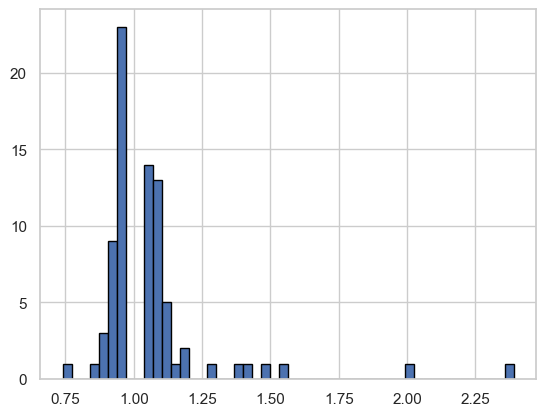

In [274]:
plt.hist(weights["OR or BETA"], bins=50, edgecolor="black")

In [303]:
# where the sign is negative, the risk allele is not the counted allele
# so for the snps, we have to do 2 - the counted allele to get the risk allele
snps_fixed = snps.copy()
snps_fixed[weights["sign"] == -1] = 2 - snps_fixed[weights["sign"] == -1]

In [304]:
snps_fixed

,H20.33.045,H20.33.044,H21.33.045,H20.33.046,H20.33.014,H21.33.046,H21.33.047,H20.33.011,H21.33.005,H21.33.001,...,R1258062,R8581591,R2750081,R2300123,R2908472,R6808939,R7423003,R4703595,R2213536,R3438797
rs6605556,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.997,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
rs10947943,0.000,1.000,0.018,0.999,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.995,0.000,0.000,0.999,0.000
rs143332484,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,...,0.000,0.000,0.011,0.000,0.004,0.000,0.000,0.002,0.000,0.000
rs75932628,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.002,0.000,0.000
rs60755019,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.006,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs450674,0.900,0.981,0.000,1.000,0.000,1.000,0.000,0.852,0.012,0.864,...,0.871,0.188,1.704,0.941,1.827,1.000,0.001,0.000,0.000,0.727
rs12446759,0.983,1.048,0.359,0.075,1.000,2.000,0.022,1.059,0.418,0.240,...,1.254,1.261,1.990,1.143,0.994,1.255,0.188,1.343,1.105,0.290
rs72824905,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.003,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000
rs16941239,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000


(array([ 1.,  1.,  3., 26.,  6., 14., 15.,  5.,  1.,  1.,  0.,  1.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.74 , 0.795, 0.85 , 0.905, 0.96 , 1.015, 1.07 , 1.125, 1.18 ,
        1.235, 1.29 , 1.345, 1.4  , 1.455, 1.51 , 1.565, 1.62 , 1.675,
        1.73 , 1.785, 1.84 , 1.895, 1.95 , 2.005, 2.06 , 2.115, 2.17 ,
        2.225, 2.28 , 2.335, 2.39 ]),
 <BarContainer object of 30 artists>)

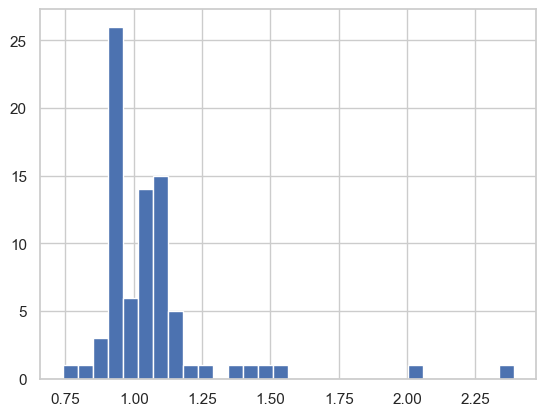

In [305]:
plt.hist(weights["OR or BETA"], bins=30)

In [309]:
prss = (np.array(snps_fixed) * weights["logOR"].values.reshape(-1, 1)).sum(axis=0)
prss = pd.Series(prss, index=snps.columns, name="PRS")

prss.to_csv("data/PRS.csv")

prss

H20.33.045   -0.139991
H20.33.044   -0.293398
H21.33.045   -0.616018
H20.33.046   -0.012919
H20.33.014   -0.156987
                ...   
R6808939     -0.857923
R7423003      0.053622
R4703595      0.016418
R2213536     -0.397821
R3438797      0.044925
Name: PRS, Length: 2107, dtype: float64

Text(0, 0.5, 'Frequency')

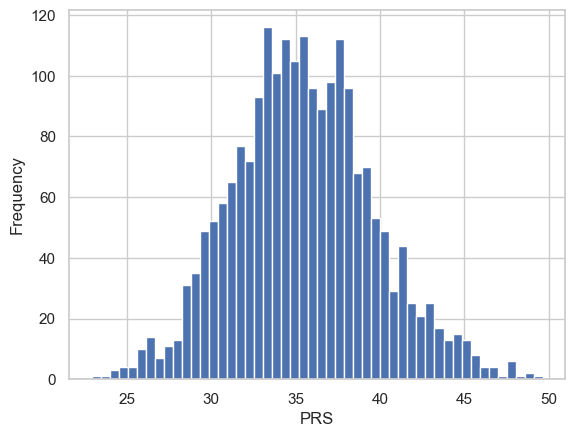

In [307]:
plt.hist(prss, bins=50)
plt.xlabel("PRS")
plt.ylabel("Frequency")

In [308]:

# validate the PRSs against the clinical metadata

clinical = pd.read_csv("data/ROSMAP_clinical.csv", index_col="individualID")
clinical_index = clinical.index

# check overlap between clinical and PRS
overlap = clinical.index.intersection(prss.index)
print(f"Found {len(overlap)} overlapping samples between clinical and PRS data.")

print(f"{clinical.shape[0] - len(overlap)} of the clinical samples are not used, and {prss.shape[0] - len(overlap)} of the PRS samples are not used.")

clinical_overlap = clinical.loc[overlap]
prss_overlap = prss.loc[overlap]

Found 2016 overlapping samples between clinical and PRS data.
1568 of the clinical samples are not used, and 91 of the PRS samples are not used.


In [291]:
clinical.columns

Index(['projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype',
       'age_at_visit_max', 'age_first_ad_dx', 'age_death',
       'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc',
       'cogdx', 'dcfdx_lv'],
      dtype='object')

In [300]:
# test statistical significance between cogdx=1 and cogdx=4 (healthy vs AD)
from scipy.stats import ttest_ind
healthy = clinical_overlap[clinical_overlap["cogdx"] == 1]
ad = clinical_overlap[clinical_overlap["cogdx"] == 4]
prs_healthy = prss_overlap.loc[healthy.index]
prs_ad = prss_overlap.loc[ad.index]
t_stat, p_value = ttest_ind(prs_healthy, prs_ad, alternative="less")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.5562654093797543, P-value: 0.005364728050305189


<Axes: xlabel='braaksc', ylabel='PRS'>

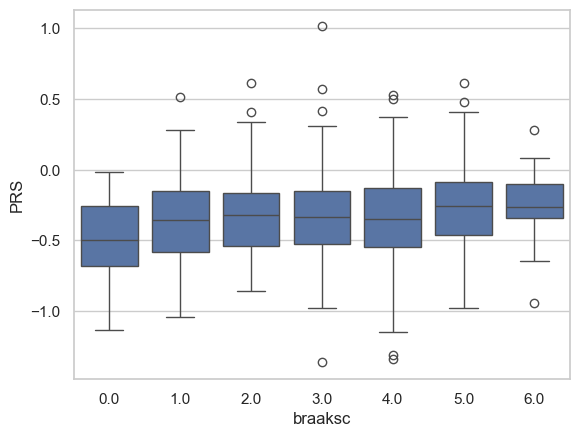

In [301]:
sns.boxplot(y=prss_overlap, x=clinical_overlap["braaksc"])

In [294]:
prss.values

array([-0.13999082, -0.29339781, -0.61601753, ...,  0.0164179 ,
       -0.39782122,  0.04492514], shape=(2107,))

In [295]:
# use the clinical data to map the Donor IDs to projid, such that we also a a mapping from the projid to the PRS

clinical["projid"]


prss_by_projid = pd.Series(prss_overlap.values, index=clinical["projid"][prss_overlap.index], name="PRS")
prss_by_projid.to_csv("data/PRS_by_projid.csv")

prss_by_projid

projid
10101589   -0.139082
86767530   -0.644672
9650662     0.206500
50402855   -0.409675
20544321   -0.124102
              ...   
11699350   -0.298839
46757148   -0.206057
74494179   -0.376261
38113465   -0.175595
90214403   -0.198236
Name: PRS, Length: 2016, dtype: float64